In [8]:
from firedrake import *
from tqdm.auto import tqdm, trange
from numpy.random import default_rng
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Numerical model of three points bending model

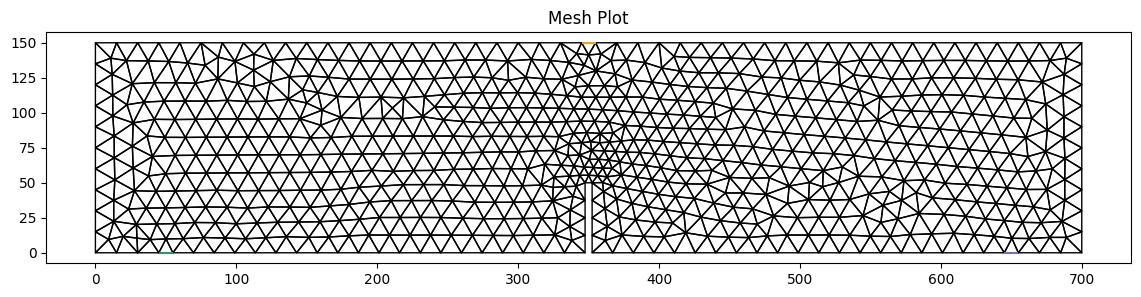

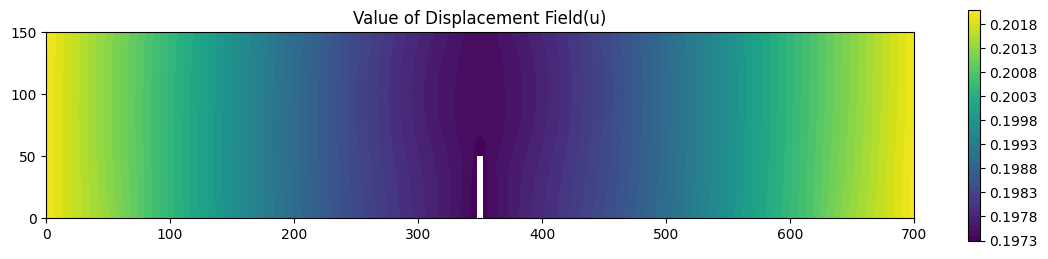

<Figure size 1400x300 with 0 Axes>

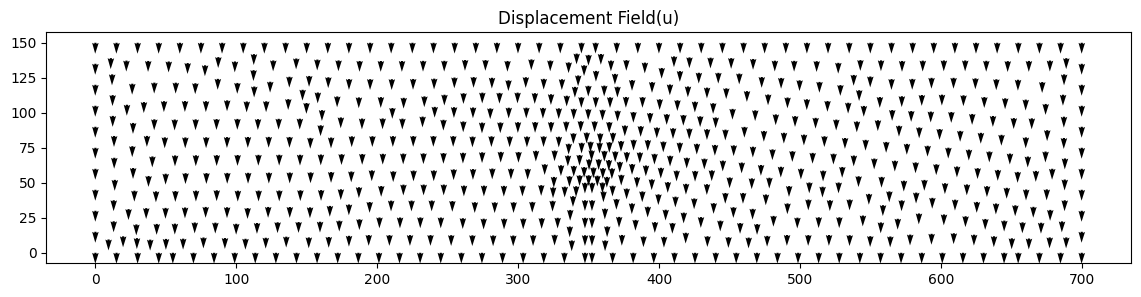

[-0.00062227  0.00108574]


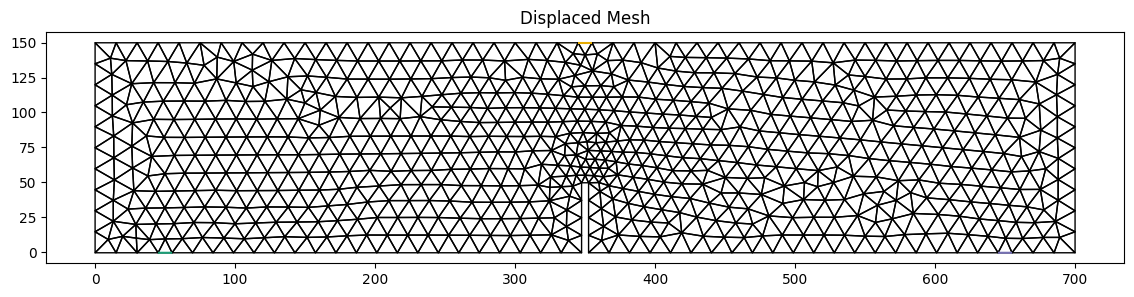

In [31]:

def forward_model(E, nu, strain_tensor):
    # Mesh refinement parameters
    # length, height = 1, 1 # in mm
    # nx, ny = 10, 10
    # mesh = RectangleMesh(nx, ny, length, height)
    mesh = Mesh("withgap.msh")
    x, y = SpatialCoordinate(mesh)
    V = VectorFunctionSpace(mesh, 'CG', 1)
    # Test and trial function for the displacement field
    v, u_ = TestFunction(V), TrialFunction(V)
    u = Function(V, name="Displacement")

    # # Plot the mesh
    fig1, ax1 = plt.subplots(figsize=(14, 3))
    triplot(mesh, axes=ax1)
    ax1.set_title("Mesh Plot")

    # Show the plot
    plt.show()

    # Lamé parameter
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    # Constitutive equations
    def eps(v):
        return 0.5*(grad(v) + grad(v).T)
    def sigma(v):
        d = 2
        return lmbda*tr(eps(v))*Identity(d) + 2*mu*eps(v)
    # Body force
    f = Constant((0.0, 0.0))
    # Facet normal vector in each boundary
    n = FacetNormal(mesh)
    
    # Convert strain tensor into displacement boundary conditions
    exx, eyy, exy = strain_tensor[0,0], strain_tensor[1,1], strain_tensor[0,1]

    # boundary conditions
    punch_u = -eyy # total imposed vertical displacement at the top loading point
    # loading by displacement control
    punch_bc = (punch_u-u[1])*dot(v, n)*ds(3)
    # weak form of the vertical displacement constraints at the bottom supports
    left_bc = (0-u[1])*dot(v, -n)*ds(1) 
    right_bc = (0-u[1])*dot(v, -n)*ds(2)
    bc = [left_bc,right_bc, punch_bc]

    F_ext = punch_bc + left_bc + right_bc # external virtual work
    F = inner(sigma(u), eps(v))*dx + F_ext #residual form of the variational problem

    # Solve PDE
    solve(F == 0, u, solver_parameters={'ksp_type': 'preonly', 'pc_type': 'lu'})
    # print(u.dat.data)

    fig1, axes = plt.subplots(figsize=(14, 3))
    axes.set_aspect('equal')
    contours = tricontourf(u, levels=50, axes=axes)
    plt.colorbar(contours)
    plt.title("Value of Displacement Field(u)")
    plt.figure(figsize=(14, 3))
    plt.show()

    # Get the coordinates of the mesh nodes
    coords = mesh.coordinates.dat.data

    # Extract the x and y displacements
    u_values = u.dat.data
    u_x = u_values[:, 0]
    u_y = u_values[:, 1]

    # Create a quiver plot
    plt.figure(figsize=(14, 3))
    plt.quiver(coords[:, 0], coords[:, 1], u_x, u_y,scale=20, width=0.002)
    plt.title("Displacement Field(u)")
    plt.show()
    
    displaced_coordinates = interpolate(SpatialCoordinate(mesh) + u, V)
    displaced_mesh = Mesh(displaced_coordinates)
    # # NBVAL_IGNORE_OUTPUT
    fig, axes = plt.subplots(figsize=(14, 3))
    axes.set_title("Displaced Mesh")

    triplot(displaced_mesh, axes=axes)
    axes.set_aspect("equal");
    
    W = TensorFunctionSpace(mesh, 'CG', 1)  # Define a tensor function space
    projected_sigma = project(sigma(u), W)

    sig = Function(W)  # Define sig as a Function over the tensor function space
    sig.assign(projected_sigma)  # Assign the projected stress to sig

    return sig

E = 30e3
nu = 0.3
strain_tensor = np.array([[0.0, 0.0],
                          [0.0, 0.6]])
s1 = forward_model(E, nu, strain_tensor)
s = s1([0,0])[0]
print(s)
# print(s1.dat.data)

In [21]:
# check
def get_dataset(ntrain,ntest, E, nu):
    X, y = [], []
    sig = []
    sigy = []
    for _ in range(ntrain + ntest):
        # Generate diagonal elements
        a11, a12, a22 = [np.random.uniform(0.1, 0.7) for _ in range(3)]
        # Construct the 2x2 matrix
        strain = np.array([[a11, a12], [a12, a22]])
        # epsilon.interpolate(as_tensor(strain))
        stress = forward_model(E, nu, strain)
    
        # print(stress.shape)
        X.append(strain[1,1])
        y.append(-stress([350,50])[1,1])
    return X, y

# Generate dataset

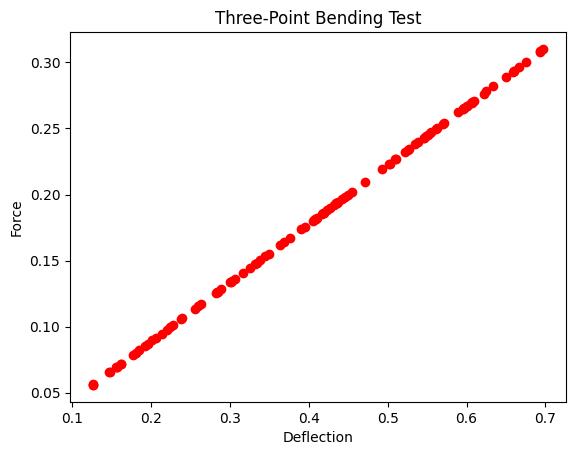

In [23]:
ntrain = 100
ntest = 10
E = Constant(2.1e3)  # Young's modulus in GPa
nu = Constant(0.3)  # Poisson's ratio
X, y = get_dataset(ntrain=ntrain, ntest=ntest, E=E, nu=nu)

# Plot the force-deflection curve
plt.plot(X, y, 'ro')
plt.xlabel("Deflection")
plt.ylabel("Force")
plt.title("Three-Point Bending Test")
plt.show()

X_train, X_test = X[:ntrain], X[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]
np.save("../data/datasets/three_point/train.npy", (X_train, y_train))
np.save("../data/datasets/three_point/test.npy", (X_test, y_test))


# Standardion

In [24]:
X_test,y_test = np.load("../data/datasets/three_point/test.npy")
X_train, y_train = np.load("../data/datasets/three_point/train.npy")

# Min-Max Normalization
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

X_train_norm = min_max_normalize(X_train)
y_train_norm = min_max_normalize(y_train)
X_test_norm = min_max_normalize(X_test)
y_test_norm = min_max_normalize(y_test)

# Standardization
# Z-score Normalization (Standardization)
def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

X_train_norm = standardize(X_train)
y_train_norm = standardize(y_train)
X_test_norm = standardize(X_test)
y_test_norm = standardize(y_test)

# print("X_train",X_train_norm)
# print("y_train",y_train_norm)

# X_train_norm, y_train_norm = normalize_data(X_train, y_train)
# X_test_norm, y_test_norm = normalize_data(X_test, y_test)

# Train

In [25]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler

# Define your machine learning model
class MLP_model(nn.Module):
    def __init__(self):
        super(MLP_model, self).__init__()
        # Define your model architecture
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 4)
        self.fc3 = nn.Linear(4, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=2000, lr=0.00025):
    # Convert data to PyTorch tensors and extract upper triangle
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    test_losses = []
    # Training loop
    for epoch in range(epochs):
        # Forward pass
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        losses.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_losses.append(test_loss.item())
        # Print loss every 10 epochs
        # if (epoch+1) % 10 == 0:
            # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    # Print final loss
    print(f'Final loss: {loss.item():.4f}')
    print(f'Final test loss: {test_loss.item():.4f}')
    plt.plot(test_losses)
    plt.plot(losses)
    # Evaluate the model on the test set

Final loss: 0.9807
Final test loss: 0.9805


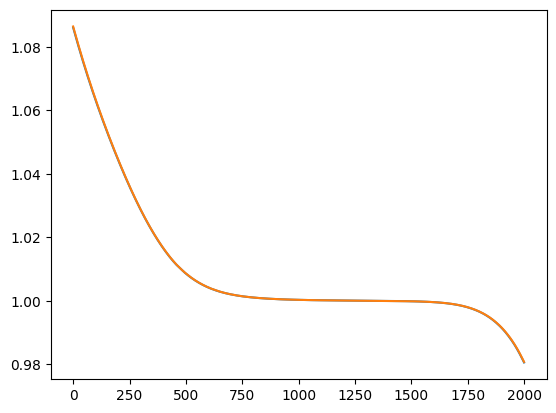

In [27]:
# Initialize the model
model = MLP_model()

# Standardize the data
X_train_norm = standardize(X_train)
y_train_norm = standardize(y_train)
X_test_norm = standardize(X_test)
y_test_norm = standardize(y_test)

# Train the model
train_model(model, X_train_norm, y_train_norm, X_test_norm, y_test_norm)
